In [1]:
%matplotlib inline
import PIL as PIL
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from scipy import fftpack
from scipy.ndimage.filters import gaussian_filter

import pandas as pd
import cv2
import scipy.stats as st
from scipy.signal import convolve2d
from skimage import color, data, restoration
import skimage.util
plt.rcParams["figure.figsize"] = (12,8)

In [67]:
im = PIL.Image.open('input1.bmp')
im = np.array(im)
im_ori = PIL.Image.open('input1_ori.bmp')
im_ori = np.array(im_ori)
im_R = im[:,:,0].copy()
im_G = im[:,:,1].copy()
im_B = im[:,:,2].copy()


### 觀察頻率空間

In [51]:
octaveDivisions = 10
numOfOctaves = 5
scaleFactor = np.power(2.0,1.0/octaveDivisions)
numOfLevels = octaveDivisions*numOfOctaves+1
sigma = np.zeros(numOfLevels)
sigma[0] = 1
for i in range(1,numOfLevels):
    sigma[i] = sigma[i-1]*scaleFactor

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


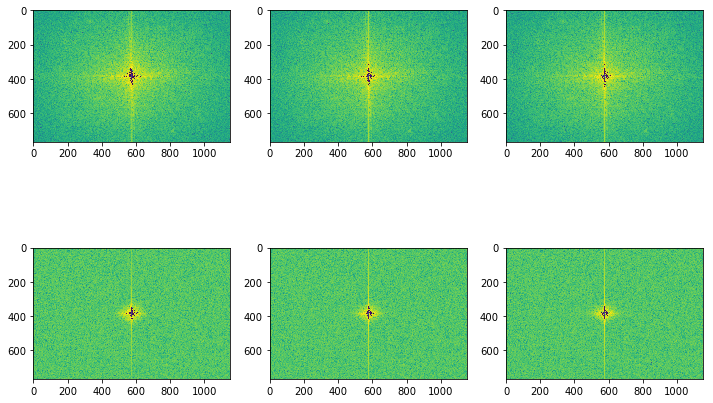

In [52]:
f,ax = plt.subplots(2,3)
for i in range(3):
    img_float32 = np.float32(im_ori[:,:,i])
    dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    ax[0][i].imshow(magnitude_spectrum.astype(np.uint8))
for i in range(3):
    img_float32 = np.float32(im[:,:,i])
    dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    ax[1][i].imshow(magnitude_spectrum.astype(np.uint8))   
f.show()


### 估測sigma

In [53]:
E = np.zeros(numOfLevels) 
E_diff = np.zeros(numOfLevels-1)
H = np.zeros(im_R.shape)
for i in range(numOfLevels):
    E[i] = LA.norm(np.float64(im_R)-gaussian_filter(np.float64(im_R),sigma=sigma[i]))
for i in range(numOfLevels-1):
    E_diff[i] = (E[i+1]-E[i])/(sigma[i+1]-sigma[i])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:3318: RuntimeWarning: Second argument is ambiguous: could be a color spec but is in data. Using as data.
Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


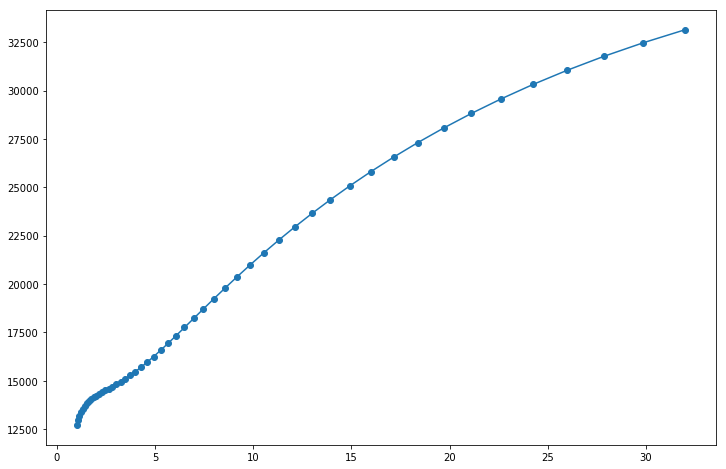

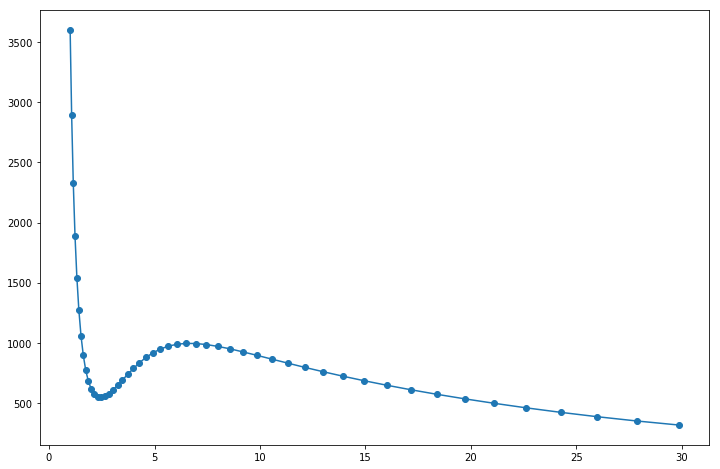

In [54]:
df=pd.DataFrame({'x': sigma, 'y': E })
plt.plot('x', 'y',data=df,linestyle='-', marker='o')
plt.show()

df2=pd.DataFrame({'x': sigma[:-1], 'y': E_diff })
plt.plot('x', 'y',data=df2,linestyle='-', marker='o')
plt.show()

#### 產生高斯核

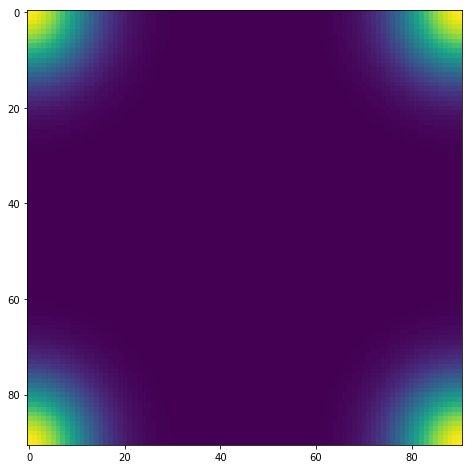

In [55]:
def gkern2(kernSize=(21,21), nsig=3):
    """Returns a 2D Gaussian kernel array."""

    # create nxn zeros
    inp = np.zeros(kernSize,dtype=np.float64)
    # set element at the middle to one, a dirac delta
    inp[0, 0] = 1.0/4.0
    inp[0,kernSize[1]-1] = 1.0/4.0
    inp[kernSize[0]-1,0] = 1.0/4.0
    inp[kernSize[0]-1, kernSize[1]-1] = 1.0/4.0
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    g = gaussian_filter(inp, nsig)
    return g/g.sum()
def gkern2_cent(kernSize=(21,21), nsig=3):
    """Returns a 2D Gaussian kernel array."""

    # create nxn zeros
    inp = np.zeros(kernSize,dtype=np.float64)
    # set element at the middle to one, a dirac delta
    inp[kernSize[0]//2, kernSize[1]//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    return gaussian_filter(inp, nsig)


kernel2 = gkern2_cent((51,51),nsig=9.0)
plt.imshow(gkern2((91,91),nsig=9.0))
plt.show()



### Padding Input

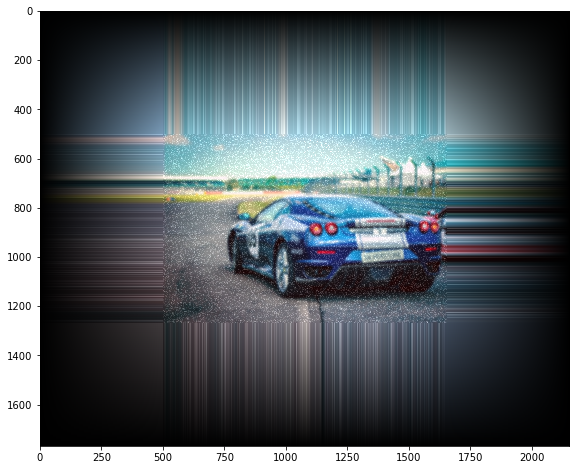

dtype('float64')

In [56]:
pad_width = 500
im_pad = np.zeros((im.shape[0]+pad_width*2,im.shape[1]+pad_width*2,3),np.float64)

for i in range(3):
    im_pad[:,:,i] = skimage.util.pad(im[:,:,i],mode='linear_ramp',pad_width=pad_width,end_values=0.0)
plt.imshow(im_pad.astype(np.uint8))
plt.show()
im_R_pad = im_pad[:,:,0]
im_pad.dtype


### 若Input1 usewiener 設定False  nsig = 9.1


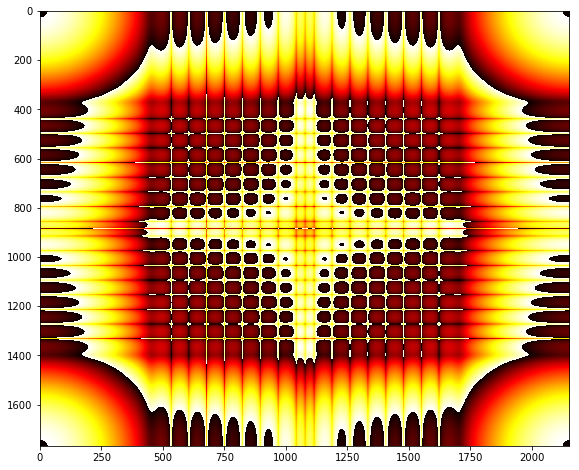

0.15
61.3862884908
58.8278298085


58.827829808452535

In [66]:
usewiener = False
kernel = gkern2((im_pad.shape[0],im_pad.shape[1]),nsig=3.5)
H = np.fft.fft2(kernel)

magnitude_spectrum = 20*np.log(np.abs(H))
plt.imshow(magnitude_spectrum.astype(np.uint8),cmap='hot')
plt.show()
# H = np.fft.fftshift(H)

def psnr(im1,im2):
    psnr = 0.0
    
    for i in range(3):
        diff = np.abs(im1[:,:,i] - im2[:,:,i])
        rmse = np.square(diff).sum()/(im2.shape[0]*im2.shape[1])
        psnr += 10*np.log10(255.0*255.0/rmse)
    print(psnr)
    return psnr

def winner(im):

    I = fftpack.fft2(im)
    H_local = H.copy()
    H_local[np.abs(H_local)<0.5] =0.1
    
    if usewiener:
        W = np.conjugate(H_local)/(np.multiply(H_local,np.conjugate(H_local))+K)
        F = np.multiply(I,W)
        f = np.fft.ifft2(F)
        f = np.real(f)
        f[f>255] = 255.0
        f[f<0] = 0.0
        return f.astype(np.uint8)

    F = np.divide(I,H_local)
    f = np.fft.ifft2(F)
    f = np.real(f)
    f[f>255] = 255.0
    f[f<0] = 0.0
    return f.astype(np.uint8)


    

    
K = 0.15
im_rec = np.zeros((im_pad.shape[0],im_pad.shape[1],3))
im_rec[:,:,0] = winner(im_pad[:,:,0])
im_rec[:,:,1] = winner(im_pad[:,:,1])
im_rec[:,:,2] = winner(im_pad[:,:,2])
output1 = im_rec[pad_width:-pad_width,pad_width:-pad_width,:]
print(K)

psnr(output1.astype(np.float64),im_ori.astype(np.float64))
psnr(im.astype(np.float64),im_ori.astype(np.float64))



